# Определение возраста покупателей
Супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация поможет определять возраст клиентов, чтобы: Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы; Контролировать добросовестность кассиров при продаже алкоголя. Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**План проекта:**

 - Проведите исследовательский анализ.
 - Подготовьте данные к обучению.
 - Обучите нейронную сеть и рассчитайте её качество.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Исследовательский анализ данных

In [2]:
#загрузка данных
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=123456)

test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=123456)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [3]:
labels.shape

(7591, 2)

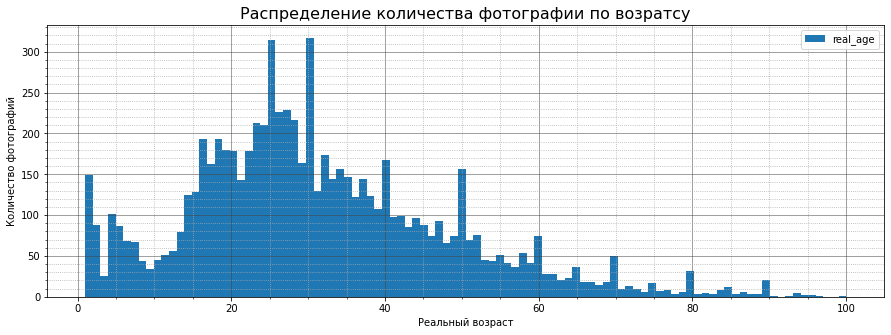

In [4]:
labels.plot(kind='hist', bins=100,
label='реальный возраст', figsize=(15, 5))
plt.minorticks_on()
plt.grid(which='major', color = '#444', linewidth = 0.5)
plt.grid(which='minor', color='#aaa', ls=':')
plt.xlabel('Реальный возраст')
plt.ylabel('Кол-во фотографий')
plt.title('Распределение кол-ва фотографии по возратсу', fontsize=16);

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [7]:
#визуальное отображение фото:
features, target = next(train_generator)

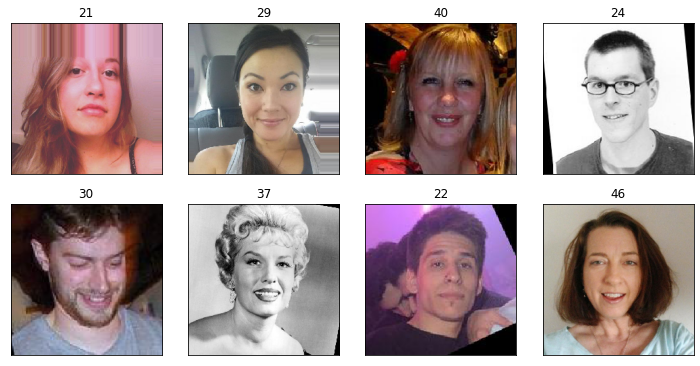

In [19]:
fig = plt.figure(figsize=(10,10))
for i in range(8, 16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:** датасет содержит 7591 фотографий. 

Разброс возраста в выборке составляет от детей, до стариков.

Больше всего фотографий в диапазоне от 20 до 41 года 

Для обучении модели подошли бы очищенные фотографии, где у потенциальных  клиентов не закрыто или искожено лицо, так же фотографии представленны в разном качестве и цветовом формате, так что все эти факторы будут усложныть обучение модели. Так же есть фотографии на которых изначально прменена некоторая аугментация. 

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

In [21]:
import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, vertical_flip=True, horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2)
    train_data = train_datagen.flow_from_dataframe(
      dataframe=labels,
      directory= path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='training',
      seed=12345)
    return train_data

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_data = test_datagen.flow_from_dataframe(
      dataframe=labels,
      directory= path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='validation',
      seed=12345)
    return test_data

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 
    model.fit(train_data,
              validation_data=test_data,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              batch_size=batch_size, epochs=epochs,
              verbose=2, shuffle=True)

    return model
 

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 188s - loss: 280.5486 - mae: 12.1732 - val_loss: 979.8577 - val_mae: 26.5667
Epoch 2/10
178/178 - 105s - loss: 115.5149 - mae: 8.1099 - val_loss: 913.7666 - val_mae: 25.3301
Epoch 3/10
178/178 - 106s - loss: 97.4419 - mae: 7.4888 - val_loss: 319.5637 - val_mae: 13.7142
Epoch 4/10
178/178 - 94s - loss: 82.8737 - mae: 6.9164 - val_loss: 160.5478 - val_mae: 9.7935
Epoch 5/10
178/178 - 96s - loss: 73.0811 - mae: 6.4861 - val_loss: 110.1112 - val_mae: 8.0493
Epoch 6/10
178/178 - 98s - loss: 65.0368 - mae: 6.1930 - val_loss: 104.4345 - val_mae: 7.7565
Epoch 7/10
178/178 - 93s - loss: 60.2072 - mae: 5.9144 - val_loss: 234.9109 - val_mae: 11.3493
Epoch 8/10
178/178 - 95s - loss: 53.5574 - mae: 5.6127 - val_loss: 98.0442 - val_mae: 7.2839
Epoch 9/10
178/178 - 98s - loss: 50.3180 - mae: 5.4376 - val_loss: 89.5542 - val_mae: 7.0079
Epoch 10/10
178/178 - 96s - loss: 48.2085 - mae: 5.3353 - val_loss: 78.0077 - val_mae: 6.5676
WARNING:tensorflow:sample_weight modes were coerced from

60/60 - 10s - loss: 78.0077 - mae: 6.5676
Test MAE: 6.5676

```

## Анализ обученной модели

Была обучена остаточная нейронная сеть (ResNet) с аугментацией (горизонтальный поворот). Цель была достичь значения средней абсолютной ошибки MAE на тестовой выборке не больше 8. Модель обучалась на 10 эпохах мы достигли значение метрики MAE 6.99, а функции потерь 89.2. Можем сделать вывод модель не переобучилась, поскольку последовательно метрика и на обучающей выборке, и на тестовой улучшалась (если бы на обучающей продолжила улучшаться, а на тестовой нет, тогда бы модель переобучилась) поэтому модель готова к использованию.

Но стоит уточнить, что погрешность в 7 лет может быть значимой для определения возраста, например при покупке алкоголя, необходимо более точно определить цель задачи, если основная задача разделить покупателей на категории, то можно сказать, что модель удовлетворительно справляется с задачей, однако, если цель задачи определять точный возраст покупателей, то модель требует дальнейшей доработки и увеличение размера датасета + балансировка групп.